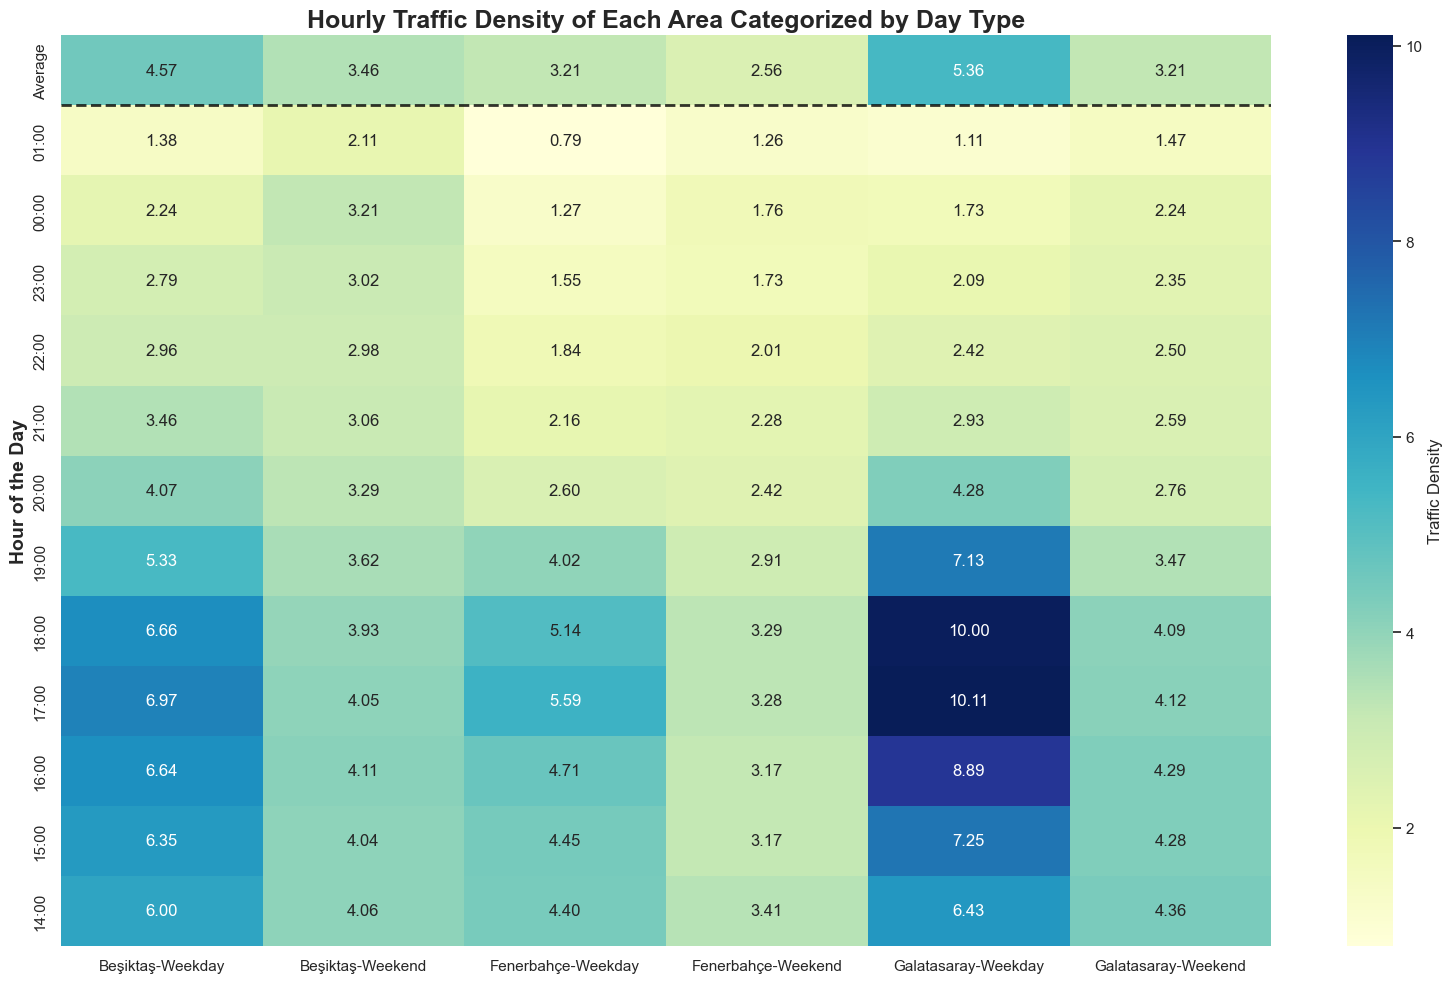

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_weekday_vs_weekend_traffic(traffic_path, team_name):
    # Load traffic data
    traffic_df = pd.read_csv(traffic_path)

    # Convert date columns to datetime format
    traffic_df['DATE_TIME'] = pd.to_datetime(traffic_df['DATE_TIME'])
    traffic_df['HOUR'] = traffic_df['DATE_TIME'].dt.hour
    traffic_df['DAY_OF_WEEK'] = traffic_df['DATE_TIME'].dt.day_name()

    # Filter hours between 14 and 1 (including overnight logic)
    traffic_df['HOUR'] = traffic_df['HOUR'].apply(lambda x: x if x >= 14 else x + 24)

    # Determine if the day is a weekend or weekday
    traffic_df['WEEKEND'] = traffic_df['DAY_OF_WEEK'].isin(['Saturday', 'Sunday'])
    traffic_df['WEEKEND'] = traffic_df['WEEKEND'].apply(lambda x: 'Weekend' if x else 'Weekday')

    # Group by hour, weekend/weekday, and calculate average traffic density
    weekday_vs_weekend = traffic_df.groupby(['WEEKEND', 'HOUR'])['traffic_density'].mean().reset_index()
    weekday_vs_weekend['TEAM'] = team_name

    return weekday_vs_weekend

def plot_heatmap_with_average(weekday_vs_weekend):
    # Prepare data for heatmap
    heatmap_data = weekday_vs_weekend.pivot_table(
        index='HOUR', 
        columns=['TEAM', 'WEEKEND'], 
        values='traffic_density'
    )

    # Adjust hour format for display and sort descending
    heatmap_data = heatmap_data.sort_index(ascending=False)
    heatmap_data.index = heatmap_data.index.map(lambda x: '00:00' if x == 24 else f"{x - 24 if x > 24 else x:02}:00")

    # Calculate general averages for each column (team & weekend/weekday combination)
    averages = heatmap_data.mean().to_frame(name='Average').T

    # Prepend averages to the heatmap data
    combined_data = pd.concat([averages, heatmap_data])

    # Create a heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        combined_data,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar_kws={'label': 'Traffic Density'}
    )

    # Add title and labels
    plt.title('Hourly Traffic Density of Each Area Categorized by Day Type', fontsize=18, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Hour of the Day', fontsize=14, fontweight='bold')

    # Add a line or spacing to separate the average row
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--', alpha=0.8)

    plt.tight_layout()
    plt.show()

# File paths for traffic data
bjk_traffic_path = 'data/besiktas_stadium_area_10km.csv'
fenerbahce_traffic_path = 'data/fenerbahce_stadium_area_10km.csv'
galatasaray_traffic_path = 'data/galatasaray_stadium_area_10km.csv'

# Analyze weekday vs weekend traffic for each team
bjk_traffic = analyze_weekday_vs_weekend_traffic(bjk_traffic_path, 'Beşiktaş')
fenerbahce_traffic = analyze_weekday_vs_weekend_traffic(fenerbahce_traffic_path, 'Fenerbahçe')
galatasaray_traffic = analyze_weekday_vs_weekend_traffic(galatasaray_traffic_path, 'Galatasaray')

# Combine data for all teams
all_traffic = pd.concat([bjk_traffic, fenerbahce_traffic, galatasaray_traffic], ignore_index=True)

# Plot heatmap for weekday vs weekend traffic with averages
plot_heatmap_with_average(all_traffic)


In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact

# Function to process data for a team
def process_team_data(matches_path, traffic_path, team_name):
    matches_df = pd.read_csv(matches_path)
    traffic_df = pd.read_csv(traffic_path)

    # Convert date columns to datetime format
    matches_df['DATE'] = pd.to_datetime(matches_df['DATE'], format='%d.%m.%Y')
    traffic_df['DATE_TIME'] = pd.to_datetime(traffic_df['DATE_TIME'])
    traffic_df['DATE'] = traffic_df['DATE_TIME'].dt.date
    traffic_df['DAY'] = traffic_df['DATE_TIME'].dt.day_name().str.upper()
    traffic_df['HOUR'] = traffic_df['DATE_TIME'].dt.hour

    # Initialize a list to store results
    results = []

    for _, row in matches_df.iterrows():
        match_date = row['DATE'].date()
        match_day = row['DAY']
        match_hour = int(row['HOUR'].split(':')[0]) if 'HOUR' in row else None  # Match hour

        # Filter traffic data for the match day (all hours)
        match_traffic = traffic_df[traffic_df['DATE'] == match_date]

        # Calculate average traffic by hour for the match day
        match_hourly = match_traffic.groupby('HOUR')['traffic_density'].mean()

        # Calculate average traffic by hour for the same weekday
        weekday_traffic = traffic_df[traffic_df['DAY'] == match_day]
        weekday_hourly = weekday_traffic.groupby('HOUR')['traffic_density'].mean()

        # Align data relative to match hour (-x to +x)
        hours_relative_to_match = range(-4, 6)  # Example: 4 hours before and 5 after the match
        relative_match_density = {hour: match_hourly.get((match_hour + hour) % 24, 0) for hour in hours_relative_to_match}
        relative_weekday_density = {hour: weekday_hourly.get((match_hour + hour) % 24, 0) for hour in hours_relative_to_match}

        results.append({
            'Match Date': match_date,
            'Match Day': match_day,
            'Match Hour': match_hour,
            'Relative Match Density': relative_match_density,
            'Relative Weekday Density': relative_weekday_density
        })

    # Prepare data for visualization
    visual_data = []
    for result in results:
        for hour, density in result['Relative Match Density'].items():
            visual_data.append({'Relative Hour': hour, 'Traffic Density': density, 'Type': 'Match Day', 'Match': result['Match Date'], 'Team': team_name})
        for hour, density in result['Relative Weekday Density'].items():
            visual_data.append({'Relative Hour': hour, 'Traffic Density': density, 'Type': 'Non-Match Day', 'Match': result['Match Date'], 'Team': team_name})

    return pd.DataFrame(visual_data)

# Plot function for a single team
def plot_team_data(team_data, team_name):
    plt.figure(figsize=(16, 10))
    sns.set_theme(style="whitegrid")
    sns.lineplot(data=team_data, x='Relative Hour', y='Traffic Density', hue='Type', style='Type', markers=True, linewidth=2.5, dashes=False)
    plt.axvline(0, color='white', linestyle='--', linewidth=1)
    plt.axvline(2, color='white', linestyle='--', linewidth=1)
    plt.fill_betweenx(y=[team_data['Traffic Density'].min(), team_data['Traffic Density'].max()], x1=0, x2=2, color='gray', alpha=0.2)
    plt.title(f'Traffic Density Relative to Match Time ({team_name})', fontsize=20, fontweight='bold')
    plt.xlabel('Hours Relative to Match Start', fontsize=18, fontweight='bold')
    plt.ylabel('Traffic Density', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=15, frameon=False)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# File paths
bjk_matches_path = 'data/bjkmatches.csv'
fb_matches_path = 'data/fbmatches.csv'
gs_matches_path = 'data/gsmatches.csv'
bjk_traffic_path = 'data/besiktas_stadium_area_10km.csv'
fb_traffic_path = 'data/fenerbahce_stadium_area_10km.csv'
gs_traffic_path = 'data/galatasaray_stadium_area_10km.csv'

# Process data for each team
bjk_data = process_team_data(bjk_matches_path, bjk_traffic_path, 'Beşiktaş')
fb_data = process_team_data(fb_matches_path, fb_traffic_path, 'Fenerbahçe')
gs_data = process_team_data(gs_matches_path, gs_traffic_path, 'Galatasaray')

# Interactive selection
def show_plot(team):
    if team == 'Beşiktaş':
        plot_team_data(bjk_data, 'Beşiktaş')
    elif team == 'Fenerbahçe':
        plot_team_data(fb_data, 'Fenerbahçe')
    elif team == 'Galatasaray':
        plot_team_data(gs_data, 'Galatasaray')

interact(show_plot, team=['Beşiktaş', 'Fenerbahçe', 'Galatasaray'])


interactive(children=(Dropdown(description='team', options=('Beşiktaş', 'Fenerbahçe', 'Galatasaray'), value='B…

<function __main__.show_plot(team)>

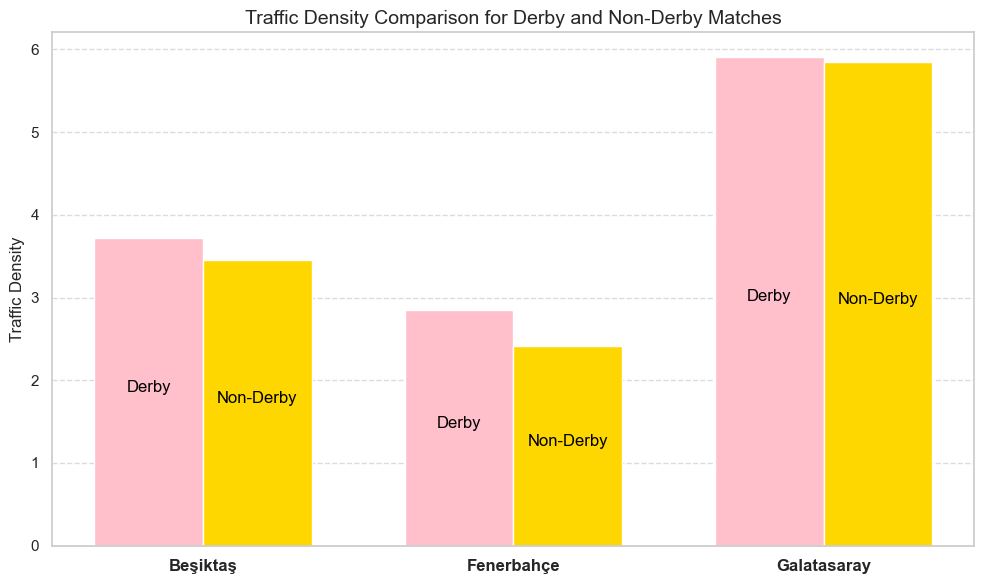

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess data
df_besiktas = pd.read_csv('data/besiktas_stadium_area_10km.csv')
df_besiktas['DATE_TIME'] = pd.to_datetime(df_besiktas['DATE_TIME'])

df_fenerbahce = pd.read_csv('data/fenerbahce_stadium_area_10km.csv')
df_fenerbahce['DATE_TIME'] = pd.to_datetime(df_fenerbahce['DATE_TIME'])

df_galatasaray = pd.read_csv('data/galatasaray_stadium_area_10km.csv')
df_galatasaray['DATE_TIME'] = pd.to_datetime(df_galatasaray['DATE_TIME'])

# Function to calculate daily average traffic excluding match hours and the following hour
def calculate_daily_average_excluding_match_hours(df, match_date, match_time, match_duration=2):
    match_day = pd.to_datetime(match_date).date()
    match_start_time = pd.to_datetime(match_time).time()
    match_end_time_plus_one = (pd.to_datetime(match_time) + pd.to_timedelta(match_duration + 1, unit='h')).time()

    mask = (df['DATE_TIME'].dt.date == match_day) & ~(
        (df['DATE_TIME'].dt.time >= match_start_time) & (df['DATE_TIME'].dt.time < match_end_time_plus_one)
    )

    values = df[mask]['traffic_density'].values
    if len(values) > 0:
        return sum(values) / len(values)
    return 0

# Function to check if a date is a weekend
def is_weekend(date_str):
    date = pd.to_datetime(date_str).date()
    return date.weekday() >= 5  # Saturday (5) and Sunday (6)

# Function to check if a date is a weekday
def is_weekday(date_str):
    date = pd.to_datetime(date_str).date()
    return date.weekday() < 5  # Monday (0) to Friday (4)

# Beşiktaş analysis
besiktas_specific = calculate_daily_average_excluding_match_hours(df_besiktas, '2024-12-07', '19:00:00')  # Derby day

besiktas_dates = [
    ('2024-08-18', '21:00:00'),
    ('2024-09-01', '21:00:00'),
    ('2024-09-22', '20:00:00'),
    ('2024-10-20', '16:00:00'),
    ('2024-11-02', '19:00:00'),
    ('2024-11-24', '19:00:00')
]

besiktas_weekend_dates = [(date, time) for date, time in besiktas_dates if is_weekend(date)]
besiktas_weekend_values = [
    calculate_daily_average_excluding_match_hours(df_besiktas, date, time) for date, time in besiktas_weekend_dates
]
besiktas_avg_weekend = sum(besiktas_weekend_values) / len(besiktas_weekend_values) if besiktas_weekend_values else 0

# Fenerbahçe analysis
fenerbahce_specific = calculate_daily_average_excluding_match_hours(df_fenerbahce, '2024-09-21', '20:00:00')  # Derby day

fenerbahce_dates = [
    ('2024-08-10', '21:00:00'),  
    ('2024-08-30', '21:00:00'),  
    ('2024-09-21', '20:00:00'),  
    ('2024-10-27', '19:00:00'),  
    ('2024-11-10', '19:00:00'),  
    ('2024-12-02', '20:00:00'),  
    ('2024-12-15', '19:00:00')   
]

fenerbahce_weekend_dates = [(date, time) for date, time in fenerbahce_dates if is_weekend(date)]
fenerbahce_weekend_values = [
    calculate_daily_average_excluding_match_hours(df_fenerbahce, date, time) for date, time in fenerbahce_weekend_dates
]
fenerbahce_avg_weekend = sum(fenerbahce_weekend_values) / len(fenerbahce_weekend_values) if fenerbahce_weekend_values else 0

# Galatasaray analysis
galatasaray_specific = calculate_daily_average_excluding_match_hours(df_galatasaray, '2024-10-28', '20:00:00')  # Derby day

galatasaray_dates = [
    ('2024-08-09', '21:00:00'),  
    ('2024-09-14', '20:00:00'),  
    ('2024-09-17', '20:00:00'),  
    ('2024-09-28', '19:00:00'),  
    ('2024-10-06', '19:00:00'),  
    ('2024-10-28', '20:00:00'),  
    ('2024-11-10', '16:00:00')   
]

galatasaray_weekday_dates = [(date, time) for date, time in galatasaray_dates if is_weekday(date)]
galatasaray_weekday_values = [
    calculate_daily_average_excluding_match_hours(df_galatasaray, date, time) for date, time in galatasaray_weekday_dates
]
galatasaray_avg_weekday = sum(galatasaray_weekday_values) / len(galatasaray_weekday_values) if galatasaray_weekday_values else 0

# Visualization
plt.figure(figsize=(10, 6))
x = np.array([1, 2, 3])
width = 0.35

bars1 = plt.bar(x - width, [besiktas_specific, fenerbahce_specific, galatasaray_specific], width, color='pink', label='Derby Match Day')
bars2 = plt.bar(x, [besiktas_avg_weekend, fenerbahce_avg_weekend, galatasaray_avg_weekday], width, color='gold', label='Normal Match Day')

# Adding labels inside the bars
for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 'Derby', ha='center', fontsize=12, color='black')

for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 'Non-Derby', ha='center', fontsize=12, color='black')

# Center team names between the bars
plt.title('Traffic Density Comparison for Derby and Non-Derby Matches', fontsize=14)
plt.ylabel('Traffic Density', fontsize=12)
plt.xticks(x - width / 2, ['Beşiktaş', 'Fenerbahçe', 'Galatasaray'], fontsize=12, fontweight='bold')

# Remove vertical grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis='x')

plt.tight_layout()
plt.show()
